Este notebook tiene la información como fueron creadas las matrices de coeficientes técnicos y las imágenes de los grafos

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import networkx as nx
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
paises_region = ['Argentina', 'Bolivia', 'Brasil', 'Chile', 'Colombia', 'Ecuador',\
          'Paraguay', 'Peru','Sudamerica', 'Uruguay', 'Venezuela']

# Creación de redes

Para crear las redes, necesitamos crear las matrices de coeficientes técnicos las cuales proviene de las matrices de insumo producto

Exportamos todas las matrices de insumo producto del notebook pasado

In [ ]:
dir_matrices_IP= sorted(glob.glob(\
    r'... Introduzca dirección ... /01 - Datos y limpieza/01 - Matrices de insumo producto/*.csv'))

matrices_IP = dict( (pais, df) for pais, df in zip(paises_region, map(pd.read_csv, dir_matrices_IP)))

## Matrices de coeficientes técnicos

Usando las matrices de insumo producto calculamos las matrices de coeficientes técnicos con la siguiente función

##### Funcion matriz_coef_tec

In [4]:
def matriz_coef_tec(matriz_IP):
    '''
    Esta función calcula la matriz de coeficientes técnicos
    dada un matriz de insumo-producto en la variable 'matriz_IP'.
    
    Parámetros
    ----------
    matriz_IP : DataFrame de la libreria de pandas 
      DataFrame con la matriz de insumo producto 
    
    Resultados
    -------
    matriz_CT : DataFrame de la libreria de pandas 
      Un dataframe con la matriz de coeficientes técnicos
    '''
    
    matriz_IP_copy= matriz_IP.copy()
    matriz_IP_copy.set_index('Sector', inplace=True)
    sectores  = matriz_IP_copy.index[:40]
    matriz_CT = pd.DataFrame(columns=sectores)

    for sector in sectores:
        matriz_CT.loc[sector] = matriz_IP_copy.loc[sector][:40]/matriz_IP_copy['DT a PB'][:40]

    matriz_CT.fillna(0, inplace=True)
                
    return matriz_CT

Ordenamos las matrices en un diccionario para un acceso más fácil

In [5]:
matrices_CT = dict((pais, matriz_coef_tec(matrices_IP[pais])) for pais in paises_region)

### Exportando las matrices

In [6]:
try:
    os.mkdir('01 - Matrices de coeficientes tecnicos')
    
except:
    print('La carpeta y los archivos han sido creados')
    
for pais in paises_region:
    matrices_CT[pais].to_csv(\
        r'01 - Matrices de coeficientes tecnicos/'+pais+'_matriz_CT.csv', index=False)

---

# Creando los grafos

Transformamos las matrices de coeficientes técnicos a grafos dirigidos de Networkx 

In [7]:
grafos= dict((pais ,nx.from_pandas_adjacency(matrices_CT[pais], create_using=nx.DiGraph()))
             for pais in paises_region)

## Dibujando los grafos

Para obtener una representación visual de los grafos usamos la siguinete función

##### Funcion dibuja_grafo

In [8]:
import pygraphviz as pgv
from IPython.display import Image

In [9]:
def dibuja_grafo(nombre_archivo, grafo, matriz_grafo, lista_color, mostrar_grafo=False):
    
    '''
    This function compute a graphviz draw given a graph from
    networkx, its adjacency matrix, and list with the colors in
    hexadecimal system
    
    
    Parámetros
    ----------
    nombre_archivo : cadena
      El nombre que el usuario quiere dar al archivo de salida.
        
    grafo : networkx.DiGraph
      El grafo de networkx a dibujar
      
    matriz_grafo : numpy array
      La matriz de adyacencia del parámetro 'grafo'
      
    lista_color : lista
      Una lista con códigos de colores hexadecimales para dibujar los nodos
      
    mostrar_grafo : booleano, opcional (default=False)
     Si True, la función muestra el gráfico en la salida
      
    
    Resultados
    -------
    imagen : imagen jpg
      La imagen se guardará en el directorio donde está almacenado el notebook
      
    imagen_salida : IPython.core.display.Image (Si mostrar_grafo = True )
      Además, la función mostrará el dibujo del grafo.
    
    '''


    pgv_grafo = nx.drawing.nx_agraph.to_agraph(grafo)
    
    if isinstance(matriz_grafo, np.ndarray):
        matrix = matriz_grafo
    else:
        matrix = matriz_grafo.to_numpy()
    

    pgv_grafo.node_attr['margin'] = 15
    pgv_grafo.node_attr["style"] = "filled"
    pgv_grafo.node_attr["shape"] = "circle"
    pgv_grafo.node_attr['fixedsize'] = True
    pgv_grafo.node_attr['fontcolor'] = "white"
    #pgv_grafo.node_attr['fontsize'] = 15
    #pgv_grafo.node_attr['width'] = 5

    n = len(grafo)
    
    for i in range(n):
        node = pgv_grafo.get_node(i+1)
        node.attr["fillcolor"] = lista_color[i]

    pgv_grafo.edge_attr["arrowsize"] = 0.2    
    pgv_grafo.edge_attr["penwidth"] = 0.1
    pgv_grafo.edge_attr["style"] = "bold"

    for i in range(n):
        for j in range(n):
            if matrix[i,j] == 0: continue
            edge = pgv_grafo.get_edge(i+1, j+1)
            edge.attr["weight"] = matrix[i,j]


    pgv_grafo.graph_attr["overlap"] = False
    pgv_grafo.graph_attr["K"] = 1000.0
    pgv_grafo.graph_attr["repulsiveforce"] = 60.0
    pgv_grafo.graph_attr["splines"] = "compound"
    pgv_grafo.graph_attr['dpi'] = 300.0
    pgv_grafo.layout(prog="fdp")
    

    pgv_grafo.draw(nombre_archivo+".png")
    
    if mostrar_grafo:
        return Image(filename = nombre_archivo+".png")

### Colores

In [10]:
hexa = [ str(hex(i))[-1]  for i in range(0,16)] 

colores = ["#"+''.join([np.random.choice(hexa) for j in range(6)]) \
             for i in range(40)]

### Cambio de nombres a los nodos de los grafos

Debido a que los nombres de los sectores suele ser muy largo para que quepa en la imagen de un grafo, si cambiaran los nodos por numeros

In [11]:
sectores = list(matrices_CT['Argentina'].columns)
numero_sectores= dict( (sector, i) for i, sector in enumerate(sectores, start=1))

In [12]:
grafos_dibujar= dict((pais,nx.relabel_nodes(grafos[pais], numero_sectores)) for pais in paises_region)

### Ejemplo del grafo de Argentina

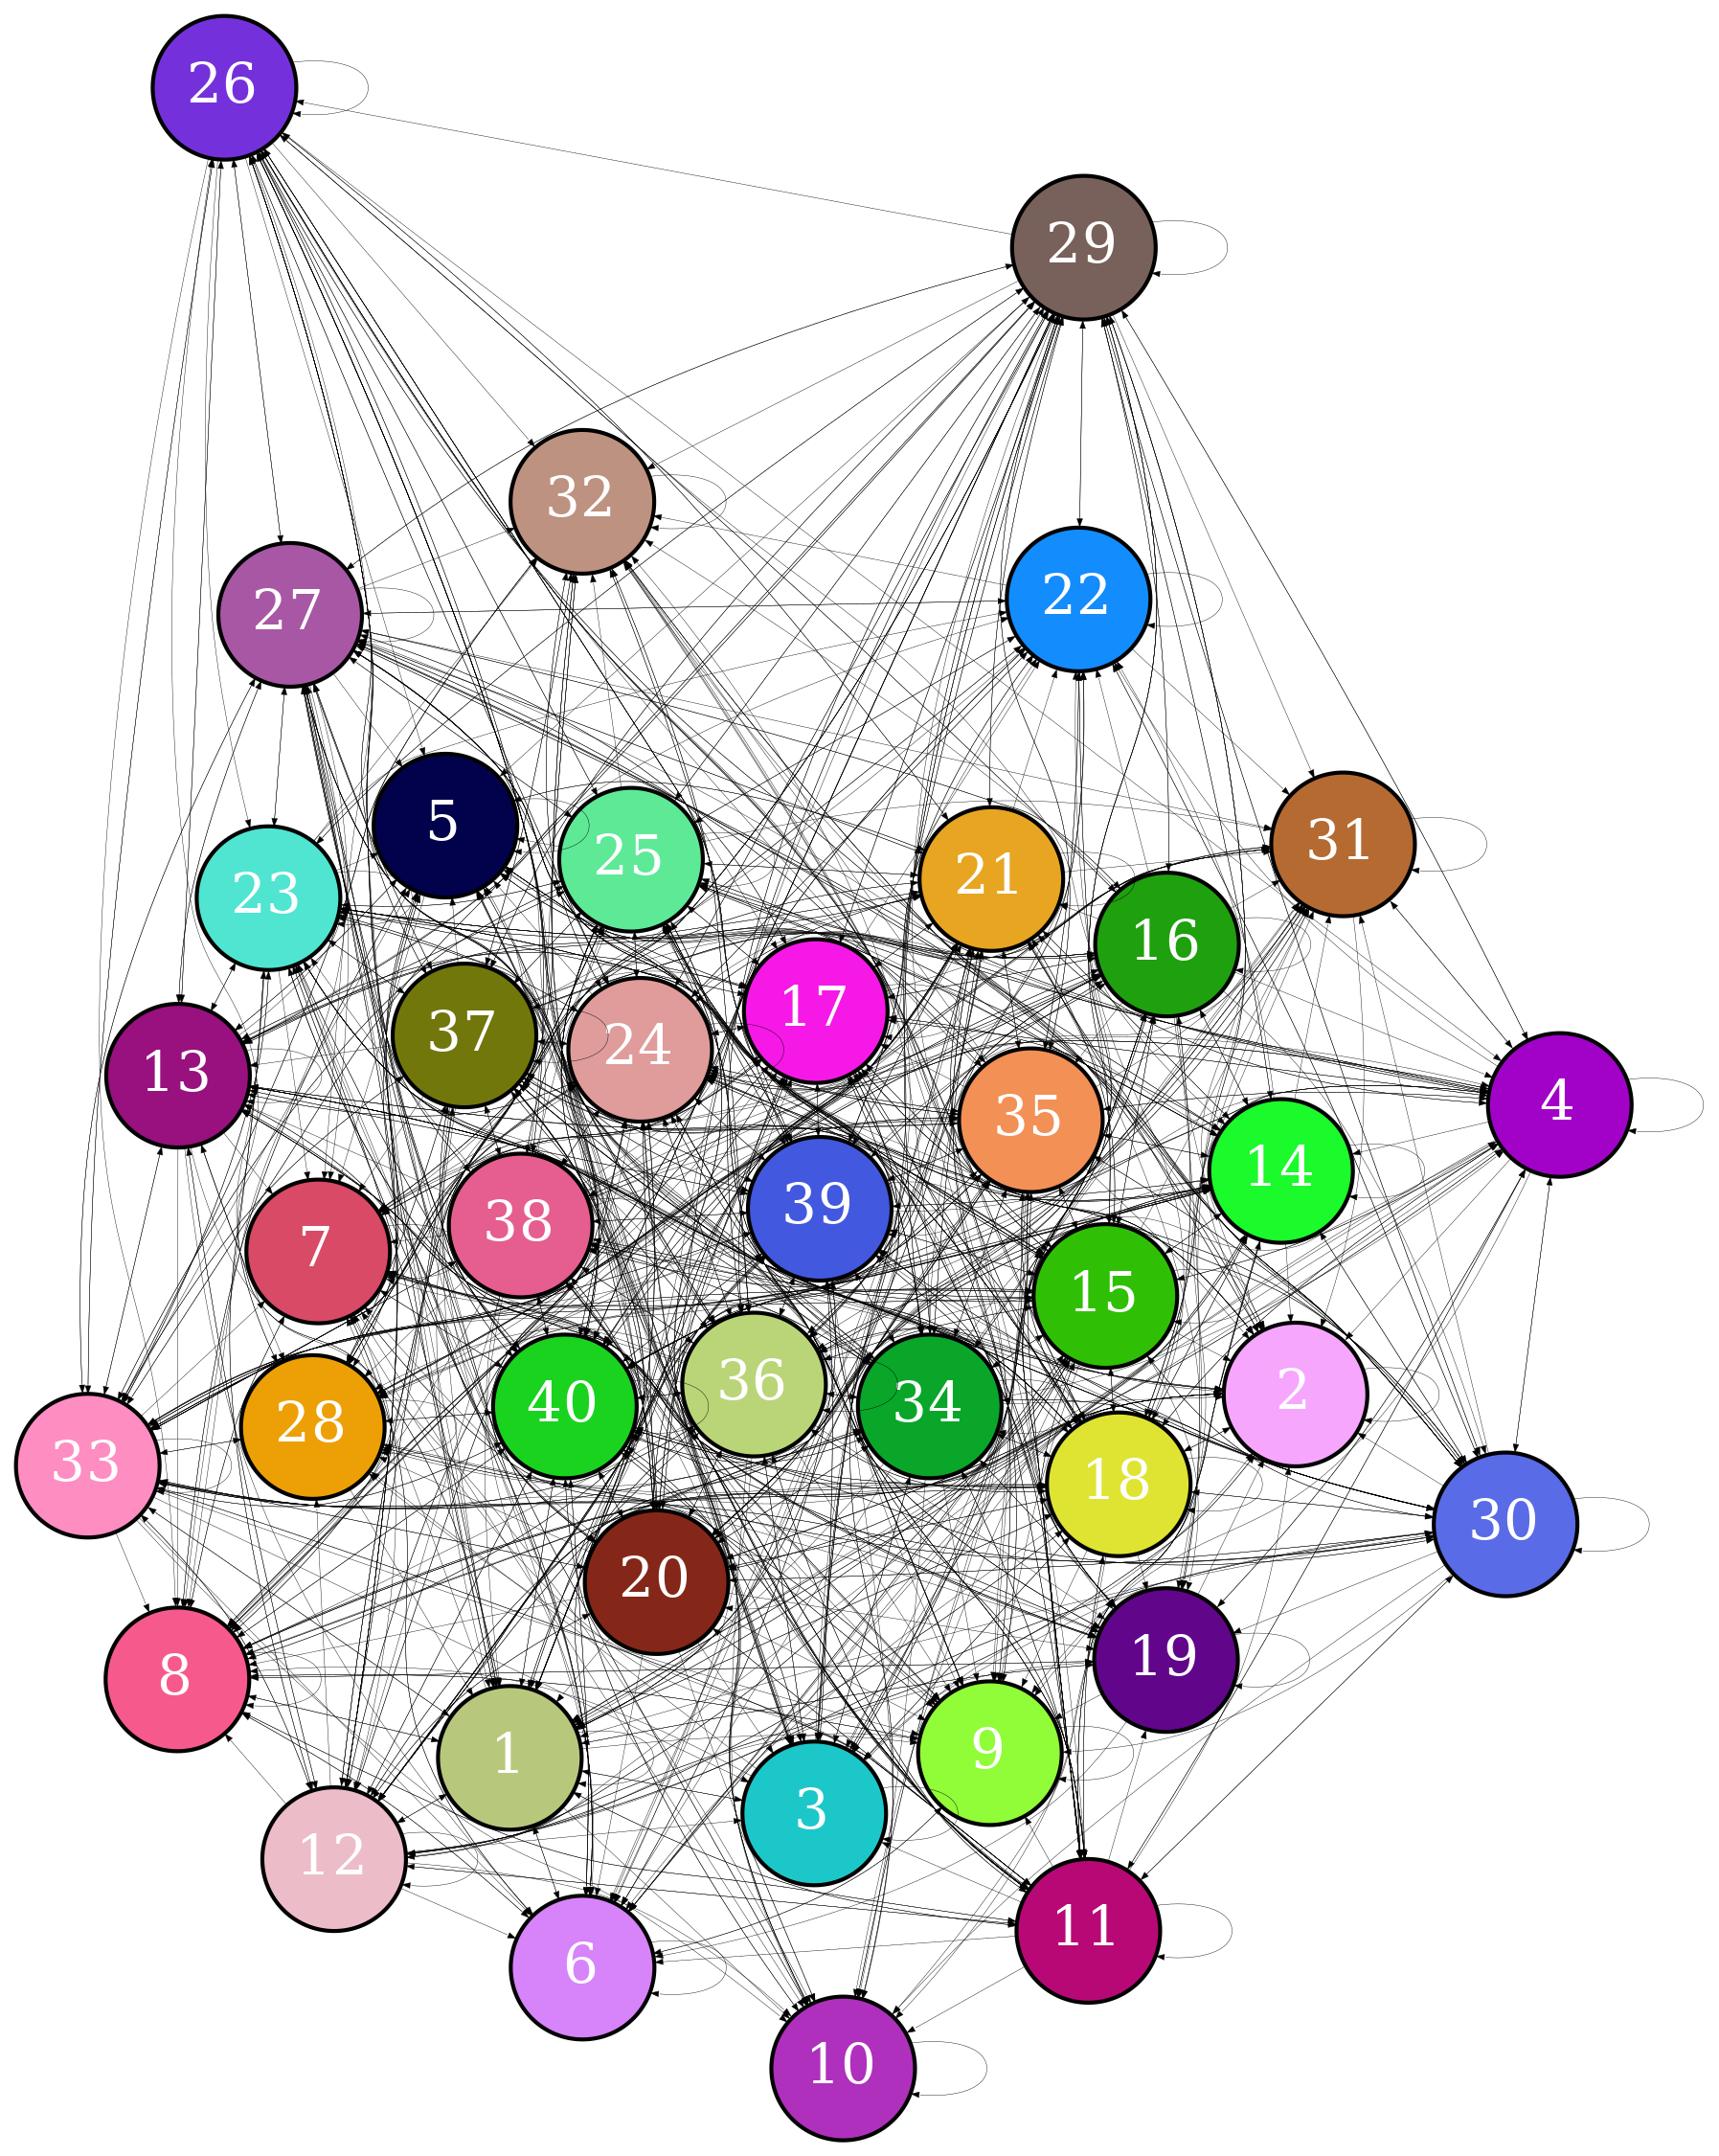

In [13]:
dibuja_grafo('Argentina',grafos_dibujar['Argentina'], matrices_CT['Argentina'],colores, mostrar_grafo=True)

### Mandamos a la funcion a dibujar los grafos y estos quedarán en las carpeta actual del notebook

#### Paises

In [14]:
for pais in paises_region:
    dibuja_grafo(pais+'_ImagenGrafo',grafos_dibujar[pais],matrices_CT[pais],colores)

## Finalmente, movemos todo a carpetas para que esté más organizado

In [15]:
from shutil import move

In [16]:
try:
    os.mkdir('02 - Imagenes grafos')
except:
    print('La carpeta ya existe')
    
try:

    for imagen in glob.glob('*.png'): 
        move(imagen, '02 - Imagenes grafos')
except:
    print('Las imagenes ya están en sus carpetas')

---

# Información del notebook

In [17]:
import session_info
session_info.show(cpu=True, html=False)

-----
networkx            2.4
numpy               1.21.2
pandas              1.3.3
pygraphviz          1.7
session_info        1.0.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.8.10 (default, Mar 13 2023, 10:26:41) [GCC 9.4.0]
Linux-5.15.0-67-generic-x86_64-with-glibc2.29
4 logical CPU cores, x86_64
-----
Session information updated at 2023-03-26 13:08
